# Week 1 - GHG Emission Prediction Internship

In [2]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib


# Check Available Sheet Names


In [3]:
import pandas as pd

excel_file = r"C:\Users\satya\Downloads\SupplyChainEmissionFactorsforUSIndustriesCommodities.xlsx"
xls = pd.ExcelFile(excel_file)

# Show all sheet names
print(xls.sheet_names)


['Cover', 'Contents', 'Data Dictionary', 'Sources', 'LCIA Factors of Other GHGs', '2016_Summary_Commodity', '2015_Summary_Commodity', '2014_Summary_Commodity', '2013_Summary_Commodity', '2012_Summary_Commodity', '2011_Summary_Commodity', '2010_Summary_Commodity', '2016_Summary_Industry', '2015_Summary_Industry', '2014_Summary_Industry', '2013_Summary_Industry', '2012_Summary_Industry', '2011_Summary_Industry', '2010_Summary_Industry', '2016_Detail_Commodity', '2015_Detail_Commodity', '2014_Detail_Commodity', '2013_Detail_Commodity', '2012_Detail_Commodity', '2011_Detail_Commodity', '2010_Detail_Commodity', '2016_Detail_Industry', '2015_Detail_Industry', '2014_Detail_Industry', '2013_Detail_Industry', '2012_Detail_Industry', '2011_Detail_Industry', '2010_Detail_Industry', 'Sheet1']


# Step 2: Load Dataset

In [12]:
import pandas as pd

# Load Excel
excel_file = r"C:\Users\satya\Downloads\SupplyChainEmissionFactorsforUSIndustriesCommodities.xlsx"
xls = pd.ExcelFile(excel_file)

# Build list of actual sheet names to load
years = range(2010, 2017)
sheet_names = [f"{year}_Summary_Industry" for year in years]

# Parse each sheet into a dict and combine
data_by_year = {year: xls.parse(sheet_name) for year, sheet_name in zip(years, sheet_names)}
df = pd.concat(data_by_year.values(), ignore_index=True)

# Preview the combined data
df.head()


,Industry Code,Industry Name,Substance,Unit,Supply Chain Emission Factors without Margins,Margins of Supply Chain Emission Factors,Supply Chain Emission Factors with Margins,Unnamed: 7,DQ ReliabilityScore of Factors without Margins,DQ TemporalCorrelation of Factors without Margins,DQ GeographicalCorrelation of Factors without Margins,DQ TechnologicalCorrelation of Factors without Margins,DQ DataCollection of Factors without Margins
0,111CA,Farms,carbon dioxide,"kg/2018 USD, purchaser price",0.525,0.057,0.582,NaN,4,3,1,4,1
1,111CA,Farms,methane,"kg/2018 USD, purchaser price",0.029,0.001,0.030,NaN,4,3,1,1,1
2,111CA,Farms,nitrous oxide,"kg/2018 USD, purchaser price",0.003,0.000,0.003,NaN,4,3,1,4,1
3,111CA,Farms,other GHGs,"kg CO2e/2018 USD, purchaser price",0.005,0.000,0.005,NaN,3,3,1,3,1
4,113FF,"Forestry, fishing, and related activities",carbon dioxide,"kg/2018 USD, purchaser price",0.232,0.024,0.256,NaN,4,3,1,4,1


In [13]:
df_2 = pd.read_excel(excel_file, sheet_name=f'{years[0]}_Detail_Industry')
df_2.head()


,Industry Code,Industry Name,Substance,Unit,Supply Chain Emission Factors without Margins,Margins of Supply Chain Emission Factors,Supply Chain Emission Factors with Margins,Unnamed: 7,DQ ReliabilityScore of Factors without Margins,DQ TemporalCorrelation of Factors without Margins,DQ GeographicalCorrelation of Factors without Margins,DQ TechnologicalCorrelation of Factors without Margins,DQ DataCollection of Factors without Margins
0,1111A0,Oilseed farming,carbon dioxide,"kg/2018 USD, purchaser price",0.414,0.073,0.487,NaN,4,3,1,4,1
1,1111A0,Oilseed farming,methane,"kg/2018 USD, purchaser price",0.001,0.001,0.002,NaN,4,3,1,1,1
2,1111A0,Oilseed farming,nitrous oxide,"kg/2018 USD, purchaser price",0.002,0.000,0.002,NaN,4,3,1,4,1
3,1111A0,Oilseed farming,other GHGs,"kg CO2e/2018 USD, purchaser price",0.002,0.000,0.002,NaN,3,3,1,3,1
4,1111B0,Grain farming,carbon dioxide,"kg/2018 USD, purchaser price",0.680,0.082,0.762,NaN,4,3,1,4,1


In [15]:
all_data = []

for year in years:
    try:
        # Read Detail_Commodity sheet
        df_com = pd.read_excel(excel_file, sheet_name=f'{year}_Detail_Commodity')
        # Read Detail_Industry sheet
        df_ind = pd.read_excel(excel_file, sheet_name=f'{year}_Detail_Industry')

        # Add Source column to identify which dataset
        df_com['Source'] = 'Commodity'
        df_ind['Source'] = 'Industry'

        # Add Year column
        df_com['Year'] = year
        df_ind['Year'] = year

        # Remove leading/trailing spaces from column names
        df_com.columns = df_com.columns.str.strip()
        df_ind.columns = df_ind.columns.str.strip()

        # Rename columns to unify schema
        df_com.rename(columns={
            'Commodity Code': 'Code',
            'Commodity Name': 'Name'
        }, inplace=True)

        df_ind.rename(columns={
            'Industry Code': 'Code',
            'Industry Name': 'Name'
        }, inplace=True)

        # Concatenate both for current year and add to list
        combined = pd.concat([df_com, df_ind], ignore_index=True)
        all_data.append(combined)

    except Exception as e:
        print(f"Error processing year {year}: {e}")


In [17]:
# Combine all yearly data into one DataFrame
final_data = pd.concat(all_data, ignore_index=True)

# See shape
print(final_data.shape)

# See column names
print(final_data.columns)

# See first few rows
print(final_data.head())

# Check datatypes
print(final_data.dtypes)


(22092, 15)
Index(['Code', 'Name', 'Substance', 'Unit',
       'Supply Chain Emission Factors without Margins',
       'Margins of Supply Chain Emission Factors',
       'Supply Chain Emission Factors with Margins', 'Unnamed: 7',
       'DQ ReliabilityScore of Factors without Margins',
       'DQ TemporalCorrelation of Factors without Margins',
       'DQ GeographicalCorrelation of Factors without Margins',
       'DQ TechnologicalCorrelation of Factors without Margins',
       'DQ DataCollection of Factors without Margins', 'Source', 'Year'],
      dtype='object')
     Code                                               Name       Substance  \
0  1111A0  Fresh soybeans, canola, flaxseeds, and other o...  carbon dioxide   
1  1111A0  Fresh soybeans, canola, flaxseeds, and other o...         methane   
2  1111A0  Fresh soybeans, canola, flaxseeds, and other o...   nitrous oxide   
3  1111A0  Fresh soybeans, canola, flaxseeds, and other o...      other GHGs   
4  1111B0          Fresh whe

In [18]:
all_data[3]

,Code,Name,Substance,Unit,Supply Chain Emission Factors without Margins,Margins of Supply Chain Emission Factors,Supply Chain Emission Factors with Margins,Unnamed: 7,DQ ReliabilityScore of Factors without Margins,DQ TemporalCorrelation of Factors without Margins,DQ GeographicalCorrelation of Factors without Margins,DQ TechnologicalCorrelation of Factors without Margins,DQ DataCollection of Factors without Margins,Source,Year
0,1111A0,"Fresh soybeans, canola, flaxseeds, and other o...",carbon dioxide,"kg/2018 USD, purchaser price",0.373,0.072,0.444,NaN,4,3,1,4,1,Commodity,2013
1,1111A0,"Fresh soybeans, canola, flaxseeds, and other o...",methane,"kg/2018 USD, purchaser price",0.001,0.001,0.002,NaN,4,3,1,1,1,Commodity,2013
2,1111A0,"Fresh soybeans, canola, flaxseeds, and other o...",nitrous oxide,"kg/2018 USD, purchaser price",0.002,0.000,0.002,NaN,4,3,1,4,1,Commodity,2013
3,1111A0,"Fresh soybeans, canola, flaxseeds, and other o...",other GHGs,"kg CO2e/2018 USD, purchaser price",0.002,0.000,0.002,NaN,3,3,1,4,1,Commodity,2013
4,1111B0,"Fresh wheat, corn, rice, and other grains",carbon dioxide,"kg/2018 USD, purchaser price",0.722,0.079,0.801,NaN,4,3,1,4,1,Commodity,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,813B00,"Civic, social, professional, and similar organ...",other GHGs,"kg CO2e/2018 USD, purchaser price",0.008,0.000,0.008,NaN,4,3,1,5,1,Industry,2013
3152,814000,Private households,carbon dioxide,"kg/2018 USD, purchaser price",0.000,0.000,0.000,NaN,4,3,1,5,1,Industry,2013
3153,814000,Private households,methane,"kg/2018 USD, purchaser price",0.000,0.000,0.000,NaN,4,3,1,5,1,Industry,2013
3154,814000,Private households,nitrous oxide,"kg/2018 USD, purchaser price",0.000,0.000,0.000,NaN,4,3,1,5,1,Industry,2013


In [19]:
len(all_data)

7

In [21]:
# Step 6: Combine all years data into single DataFrame
final_data = pd.concat(all_data, ignore_index=True)

# Preview first 10 rows
final_data.head(10)


,Code,Name,Substance,Unit,Supply Chain Emission Factors without Margins,Margins of Supply Chain Emission Factors,Supply Chain Emission Factors with Margins,Unnamed: 7,DQ ReliabilityScore of Factors without Margins,DQ TemporalCorrelation of Factors without Margins,DQ GeographicalCorrelation of Factors without Margins,DQ TechnologicalCorrelation of Factors without Margins,DQ DataCollection of Factors without Margins,Source,Year
0,1111A0,"Fresh soybeans, canola, flaxseeds, and other o...",carbon dioxide,"kg/2018 USD, purchaser price",0.398,0.073,0.470,NaN,4,3,1,4,1,Commodity,2010
1,1111A0,"Fresh soybeans, canola, flaxseeds, and other o...",methane,"kg/2018 USD, purchaser price",0.001,0.001,0.002,NaN,4,3,1,1,1,Commodity,2010
2,1111A0,"Fresh soybeans, canola, flaxseeds, and other o...",nitrous oxide,"kg/2018 USD, purchaser price",0.002,0.000,0.002,NaN,4,3,1,4,1,Commodity,2010
3,1111A0,"Fresh soybeans, canola, flaxseeds, and other o...",other GHGs,"kg CO2e/2018 USD, purchaser price",0.002,0.000,0.002,NaN,3,3,1,3,1,Commodity,2010
4,1111B0,"Fresh wheat, corn, rice, and other grains",carbon dioxide,"kg/2018 USD, purchaser price",0.659,0.081,0.740,NaN,4,3,1,4,1,Commodity,2010
5,1111B0,"Fresh wheat, corn, rice, and other grains",methane,"kg/2018 USD, purchaser price",0.008,0.001,0.009,NaN,2,3,1,1,1,Commodity,2010
6,1111B0,"Fresh wheat, corn, rice, and other grains",nitrous oxide,"kg/2018 USD, purchaser price",0.004,0.000,0.004,NaN,4,3,1,4,1,Commodity,2010
7,1111B0,"Fresh wheat, corn, rice, and other grains",other GHGs,"kg CO2e/2018 USD, purchaser price",0.004,0.000,0.004,NaN,3,3,1,3,1,Commodity,2010
8,111200,"Fresh vegetables, melons, and potatoes",carbon dioxide,"kg/2018 USD, purchaser price",0.183,0.132,0.315,NaN,3,3,1,4,1,Commodity,2010
9,111200,"Fresh vegetables, melons, and potatoes",methane,"kg/2018 USD, purchaser price",0.001,0.001,0.002,NaN,4,3,1,1,1,Commodity,2010


In [22]:
len(df)

1848

# Step 3: Data Preprocessing

In [23]:
df.columns


Index(['Industry Code', 'Industry Name', 'Substance', 'Unit',
       'Supply Chain Emission Factors without Margins',
       'Margins of Supply Chain Emission Factors',
       'Supply Chain Emission Factors with Margins', 'Unnamed: 7',
       'DQ ReliabilityScore of Factors without Margins',
       'DQ TemporalCorrelation of Factors without Margins',
       'DQ GeographicalCorrelation of Factors without Margins',
       'DQ TechnologicalCorrelation of Factors without Margins',
       'DQ DataCollection of Factors without Margins'],
      dtype='object')

In [26]:
df.isnull().sum

<bound method DataFrame.sum of       Industry Code  Industry Name  Substance   Unit  \
0             False          False      False  False   
1             False          False      False  False   
2             False          False      False  False   
3             False          False      False  False   
4             False          False      False  False   
...             ...            ...        ...    ...   
1843          False          False      False  False   
1844          False          False      False  False   
1845          False          False      False  False   
1846          False          False      False  False   
1847          False          False      False  False   

      Supply Chain Emission Factors without Margins  \
0                                             False   
1                                             False   
2                                             False   
3                                             False   
4                    

In [24]:
duplicates = final_data.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")

# Remove duplicates
final_data = final_data.drop_duplicates()



Total duplicate rows: 0


In [25]:
# Clean column names
final_data.columns = final_data.columns.str.lower().str.replace(' ', '_')


In [26]:
final_data.to_csv("cleaned_emissions_data.csv", index=False)


weak-2  

In [27]:
import pandas as pd

df = pd.read_csv("cleaned_emissions_data.csv")


In [29]:
df.columns

Index(['code', 'name', 'substance', 'unit',
       'supply_chain_emission_factors_without_margins',
       'margins_of_supply_chain_emission_factors',
       'supply_chain_emission_factors_with_margins', 'unnamed:_7',
       'dq_reliabilityscore_of_factors_without_margins',
       'dq_temporalcorrelation_of_factors_without_margins',
       'dq_geographicalcorrelation_of_factors_without_margins',
       'dq_technologicalcorrelation_of_factors_without_margins',
       'dq_datacollection_of_factors_without_margins', 'source', 'year'],
      dtype='object')

In [30]:
print(df.info())  # Checking data types and non-null counts


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22092 entries, 0 to 22091
Data columns (total 15 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   code                                                    22092 non-null  object 
 1   name                                                    22092 non-null  object 
 2   substance                                               22092 non-null  object 
 3   unit                                                    22092 non-null  object 
 4   supply_chain_emission_factors_without_margins           22092 non-null  float64
 5   margins_of_supply_chain_emission_factors                22092 non-null  float64
 6   supply_chain_emission_factors_with_margins              22092 non-null  float64
 7   unnamed:_7                                              0 non-null      float64
 8   dq_reliabilityscore_of_factors_witho

In [5]:
df.describe().T # Checking summary statistics 

,count,mean,std,min,25%,50%,75%,max
supply_chain_emission_factors_without_margins,22092.0,0.084807,0.267039,0.0,0.0,0.002,0.044,7.228
margins_of_supply_chain_emission_factors,22092.0,0.012857,0.078720,0.0,0.0,0.000,0.000,3.349
supply_chain_emission_factors_with_margins,22092.0,0.097681,0.288992,0.0,0.0,0.003,0.052,7.290
unnamed:_7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dq_reliabilityscore_of_factors_without_margins,22092.0,3.308030,0.499643,2.0,3.0,3.000,4.000,4.000
dq_temporalcorrelation_of_factors_without_margins,22092.0,2.571429,0.494883,2.0,2.0,3.000,3.000,3.000
dq_geographicalcorrelation_of_factors_without_margins,22092.0,1.000000,0.000000,1.0,1.0,1.000,1.000,1.000
dq_technologicalcorrelation_of_factors_without_margins,22092.0,2.632129,1.135661,1.0,1.0,3.000,3.000,5.000
dq_datacollection_of_factors_without_margins,22092.0,1.000000,0.000000,1.0,1.0,1.000,1.000,1.000
year,22092.0,2013.000000,2.000045,2010.0,2011.0,2013.000,2015.000,2016.000


In [31]:
df.isnull().sum() # Checking for null values in each column 


code                                                          0
name                                                          0
substance                                                     0
unit                                                          0
supply_chain_emission_factors_without_margins                 0
margins_of_supply_chain_emission_factors                      0
supply_chain_emission_factors_with_margins                    0
unnamed:_7                                                22092
dq_reliabilityscore_of_factors_without_margins                0
dq_temporalcorrelation_of_factors_without_margins             0
dq_geographicalcorrelation_of_factors_without_margins         0
dq_technologicalcorrelation_of_factors_without_margins        0
dq_datacollection_of_factors_without_margins                  0
source                                                        0
year                                                          0
dtype: int64

In [7]:
df.drop(columns=['unnamed:_7'], inplace=True)


In [10]:
print(df.columns)


Index(['code', 'name', 'substance', 'unit',
       'supply_chain_emission_factors_without_margins',
       'margins_of_supply_chain_emission_factors',
       'supply_chain_emission_factors_with_margins',
       'dq_reliabilityscore_of_factors_without_margins',
       'dq_temporalcorrelation_of_factors_without_margins',
       'dq_geographicalcorrelation_of_factors_without_margins',
       'dq_technologicalcorrelation_of_factors_without_margins',
       'dq_datacollection_of_factors_without_margins', 'source', 'year'],
      dtype='object')


In [32]:
import numpy as np

# Replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows where target variable is NaN
df.dropna(subset=['supply_chain_emission_factors_with_margins'], inplace=True)


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


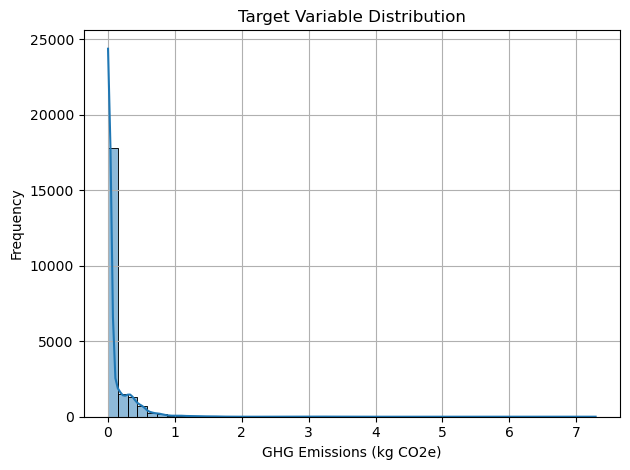

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Replace inf values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN in the target column (if needed)
# df.dropna(subset=['supply_chain_emission_factors_with_margins'], inplace=True)

# Plot
sns.histplot(df['supply_chain_emission_factors_with_margins'], bins=50, kde=True)
plt.title('Target Variable Distribution')
plt.xlabel('GHG Emissions (kg CO2e)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
print(df['substance'].value_counts())


substance
carbon dioxide    5523
methane           5523
nitrous oxide     5523
other GHGs        5523
Name: count, dtype: int64


In [35]:
print(df['unit'].value_counts())  # Checking unique values in 'unit' with count


unit
kg/2018 USD, purchaser price         16569
kg CO2e/2018 USD, purchaser price     5523
Name: count, dtype: int64


In [36]:
print(df['unit'].unique())  # Checking unique values in 'unit'


['kg/2018 USD, purchaser price' 'kg CO2e/2018 USD, purchaser price']


In [37]:
print(df['source'].value_counts())  # Checking unique values in 'source' with count


source
Industry     11060
Commodity    11032
Name: count, dtype: int64


In [38]:
df['substance'].unique()  # Checking unique values in 'substance'


array(['carbon dioxide', 'methane', 'nitrous oxide', 'other GHGs'],
      dtype=object)

In [39]:
substance_map = {
    'carbon dioxide': 0,
    'methane': 1,
    'nitrous oxide': 2,
    'other GHGs': 3
}


In [40]:
# First ensure the values are lowercase to match the mapping keys
df['substance'] = df['substance'].str.lower()

# Then map to numerical values
df['substance_encoded'] = df['substance'].map(substance_map)


In [41]:
df['substance'].unique()


array(['carbon dioxide', 'methane', 'nitrous oxide', 'other ghgs'],
      dtype=object)

In [42]:
print(df['unit'].unique())  # Checking unique values in 'unit'


['kg/2018 USD, purchaser price' 'kg CO2e/2018 USD, purchaser price']


In [43]:
unit_map = {
    'kg/2018 USD, purchaser price': 0,
    'kg CO2e/2018 USD, purchaser price': 1
}


In [44]:
# Clean first (optional but recommended)
df['unit'] = df['unit'].str.lower().str.strip()

# Apply mapping
df['unit_encoded'] = df['unit'].map(unit_map)


In [45]:
print(df['unit'].unique())


['kg/2018 usd, purchaser price' 'kg co2e/2018 usd, purchaser price']


In [46]:
print(df['source'].unique())  # Use lowercase 'source'


['Commodity' 'Industry']


In [47]:
source_map={'Commodity':0, 'Industry':1} # Mapping sources to integers 

In [48]:
# Just to be safe, clean the text
df['source'] = df['source'].str.strip()

# Apply mapping
df['source_encoded'] = df['source'].map(source_map)


In [49]:
print(df.columns.tolist())


['code', 'name', 'substance', 'unit', 'supply_chain_emission_factors_without_margins', 'margins_of_supply_chain_emission_factors', 'supply_chain_emission_factors_with_margins', 'unnamed:_7', 'dq_reliabilityscore_of_factors_without_margins', 'dq_temporalcorrelation_of_factors_without_margins', 'dq_geographicalcorrelation_of_factors_without_margins', 'dq_technologicalcorrelation_of_factors_without_margins', 'dq_datacollection_of_factors_without_margins', 'source', 'year', 'substance_encoded', 'unit_encoded', 'source_encoded']


In [50]:
df.info() # Checking data types and non-null counts after mapping

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22092 entries, 0 to 22091
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   code                                                    22092 non-null  object 
 1   name                                                    22092 non-null  object 
 2   substance                                               22092 non-null  object 
 3   unit                                                    22092 non-null  object 
 4   supply_chain_emission_factors_without_margins           22092 non-null  float64
 5   margins_of_supply_chain_emission_factors                22092 non-null  float64
 6   supply_chain_emission_factors_with_margins              22092 non-null  float64
 7   unnamed:_7                                              0 non-null      float64
 8   dq_reliabilityscore_of_factors_witho

In [51]:
# See number of unique codes
print(df['code'].nunique())

# See top occurring codes
print(df['code'].value_counts().head())

# See all unique values
print(df['code'].unique())


395
code
1111A0    56
423100    56
339990    56
339950    56
339940    56
Name: count, dtype: int64
['1111A0' '1111B0' '111200' '111300' '111400' '111900' '112120' '1121A0'
 '112300' '112A00' '113000' '114000' '115000' '211000' '212100' '212230'
 '2122A0' '212310' '2123A0' '213111' '21311A' '221100' '221200' '221300'
 '230301' '230302' '233210' '233230' '233240' '233262' '2332A0' '2332C0'
 '2332D0' '233411' '233412' '2334A0' '311111' '311119' '311210' '311221'
 '311224' '311225' '311230' '311300' '311410' '311420' '311513' '311514'
 '31151A' '311520' '311615' '31161A' '311700' '311810' '3118A0' '311910'
 '311920' '311930' '311940' '311990' '312110' '312120' '312130' '312140'
 '312200' '313100' '313200' '313300' '314110' '314120' '314900' '315000'
 '316000' '321100' '321200' '321910' '3219A0' '322110' '322120' '322130'
 '322210' '322220' '322230' '322291' '322299' '323110' '323120' '324110'
 '324121' '324122' '324190' '325110' '325120' '325130' '325180' '325190'
 '325211' '3252A0' '3253

In [52]:
df['name'].unique()  # This will work correctly


array(['Fresh soybeans, canola, flaxseeds, and other oilseeds',
       'Fresh wheat, corn, rice, and other grains',
       'Fresh vegetables, melons, and potatoes',
       'Fresh fruits and tree nuts',
       'Greenhouse crops, mushrooms, nurseries, and flowers',
       'Tobacco, cotton, sugarcane, peanuts, sugar beets, herbs and spices, and other crops',
       'Dairies', 'Cattle ranches and feedlots', 'Poultry farms',
       'Animal farms and aquaculture ponds (except cattle and poultry)',
       'Timber and raw forest products', 'Wild-caught fish and game',
       'Agriculture and forestry support', 'Unrefined oil and gas',
       'Coal', 'Copper, nickel, lead, and zinc',
       'Iron, gold, silver, and other metal ores', 'Dimensional stone',
       'Sand, gravel, clay, phosphate, other nonmetallic minerals',
       'Well drilling', 'Other support activities for mining',
       'Electricity', 'Natural gas',
       'Drinking water and wastewater treatment',
       'Nonresidential mai

In [53]:
len(df['name'].unique())  # ✅ Correct


713

Top 10 Emmiting Industry

In [54]:
top_emitters = df[['name', 'supply_chain_emission_factors_with_margins']]\
    .groupby('name').mean().sort_values(
    'supply_chain_emission_factors_with_margins', ascending=False).head(10)

top_emitters = top_emitters.reset_index()


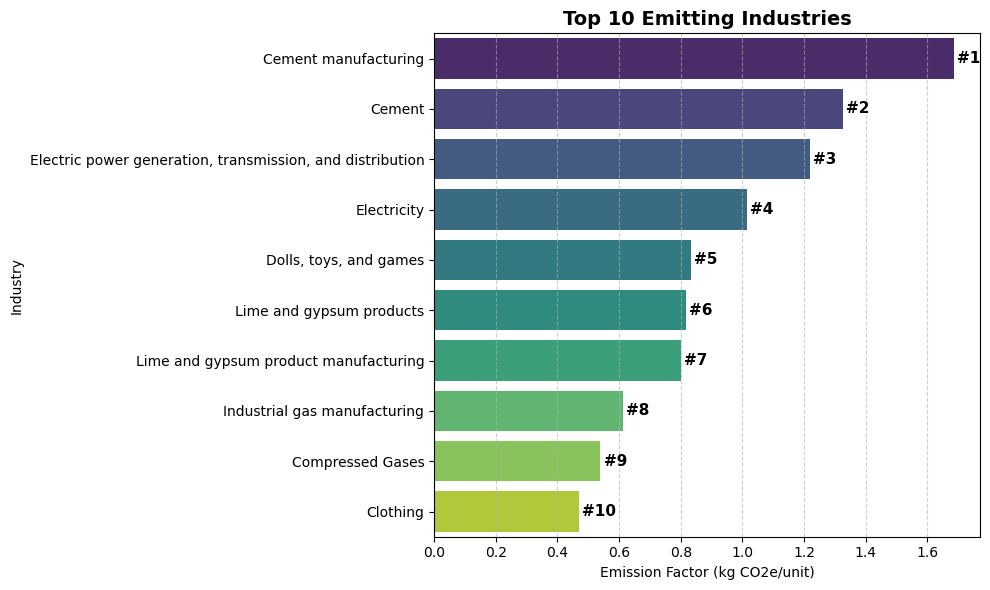

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    x='supply_chain_emission_factors_with_margins',
    y='name',
    data=top_emitters,
    palette='viridis'
)

# Add ranking labels
for i, (value, name) in enumerate(zip(top_emitters['supply_chain_emission_factors_with_margins'], top_emitters['name']), start=1):
    plt.text(value + 0.01, i - 1, f'#{i}', va='center', fontsize=11, fontweight='bold', color='black')

plt.title('Top 10 Emitting Industries', fontsize=14, fontweight='bold')
plt.xlabel('Emission Factor (kg CO2e/unit)')
plt.ylabel('Industry')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [56]:
df.drop(columns=['name', 'code', 'year'], inplace=True)


In [57]:
df.head(1)

,substance,unit,supply_chain_emission_factors_without_margins,margins_of_supply_chain_emission_factors,supply_chain_emission_factors_with_margins,unnamed:_7,dq_reliabilityscore_of_factors_without_margins,dq_temporalcorrelation_of_factors_without_margins,dq_geographicalcorrelation_of_factors_without_margins,dq_technologicalcorrelation_of_factors_without_margins,dq_datacollection_of_factors_without_margins,source,substance_encoded,unit_encoded,source_encoded
0,carbon dioxide,"kg/2018 usd, purchaser price",0.398,0.073,0.47,NaN,4,3,1,4,1,Commodity,0.0,NaN,0


In [58]:
df.shape

(22092, 15)

In [59]:
df.columns


Index(['substance', 'unit', 'supply_chain_emission_factors_without_margins',
       'margins_of_supply_chain_emission_factors',
       'supply_chain_emission_factors_with_margins', 'unnamed:_7',
       'dq_reliabilityscore_of_factors_without_margins',
       'dq_temporalcorrelation_of_factors_without_margins',
       'dq_geographicalcorrelation_of_factors_without_margins',
       'dq_technologicalcorrelation_of_factors_without_margins',
       'dq_datacollection_of_factors_without_margins', 'source',
       'substance_encoded', 'unit_encoded', 'source_encoded'],
      dtype='object')

In [60]:
X = df.drop(columns=['supply_chain_emission_factors_with_margins'])  # Feature set
y = df['supply_chain_emission_factors_with_margins']  # Target variable


In [61]:
X.head()

,substance,unit,supply_chain_emission_factors_without_margins,margins_of_supply_chain_emission_factors,unnamed:_7,dq_reliabilityscore_of_factors_without_margins,dq_temporalcorrelation_of_factors_without_margins,dq_geographicalcorrelation_of_factors_without_margins,dq_technologicalcorrelation_of_factors_without_margins,dq_datacollection_of_factors_without_margins,source,substance_encoded,unit_encoded,source_encoded
0,carbon dioxide,"kg/2018 usd, purchaser price",0.398,0.073,NaN,4,3,1,4,1,Commodity,0.0,NaN,0
1,methane,"kg/2018 usd, purchaser price",0.001,0.001,NaN,4,3,1,1,1,Commodity,1.0,NaN,0
2,nitrous oxide,"kg/2018 usd, purchaser price",0.002,0.000,NaN,4,3,1,4,1,Commodity,2.0,NaN,0
3,other ghgs,"kg co2e/2018 usd, purchaser price",0.002,0.000,NaN,3,3,1,3,1,Commodity,NaN,NaN,0
4,carbon dioxide,"kg/2018 usd, purchaser price",0.659,0.081,NaN,4,3,1,4,1,Commodity,0.0,NaN,0


In [62]:
y.head()

0    0.470
1    0.002
2    0.002
3    0.002
4    0.740
Name: supply_chain_emission_factors_with_margins, dtype: float64

Univariate Analysis

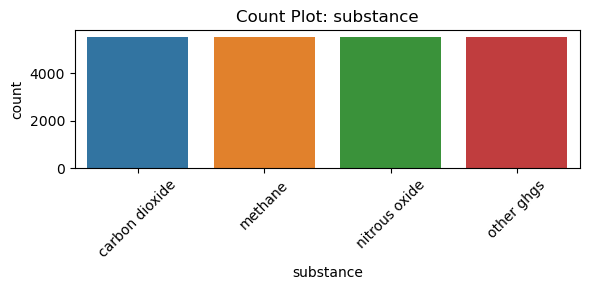

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 3))
sns.countplot(x=df["substance"])  # lowercase 'substance'
plt.title("Count Plot: substance")
plt.xticks(rotation=45)  # rotate labels if needed
plt.tight_layout()
plt.show()


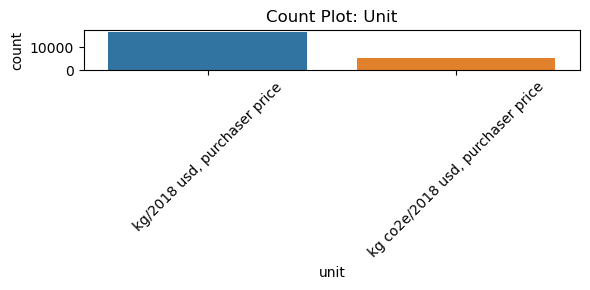

In [65]:
plt.figure(figsize=(6, 3))
sns.countplot(x=df["unit"])  # lowercase 'unit'
plt.title("Count Plot: Unit")
plt.xticks(rotation=45)  # optional, helps if labels overlap
plt.tight_layout()
plt.show()


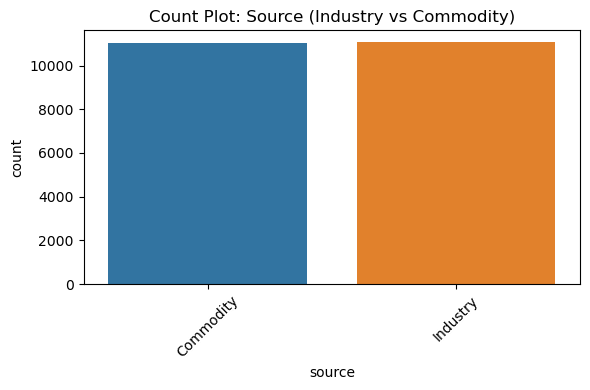

In [64]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["source"])
plt.title("Count Plot: Source (Industry vs Commodity)")
plt.xticks(rotation=45)  # optional, helps readability
plt.tight_layout()
plt.show()


In [66]:
import pandas as pd

# Load Excel
excel_file = r"C:\Users\satya\Downloads\SupplyChainEmissionFactorsforUSIndustriesCommodities.xlsx"
xls = pd.ExcelFile(excel_file)

# Build list of actual sheet names to load
years = range(2010, 2017)
sheet_names = [f"{year}_Summary_Industry" for year in years]

# Parse each sheet into a dict and combine
data_by_year = {year: xls.parse(sheet_name) for year, sheet_name in zip(years, sheet_names)}
df = pd.concat(data_by_year.values(), ignore_index=True)

# Preview the combined data
df.head()


,Industry Code,Industry Name,Substance,Unit,Supply Chain Emission Factors without Margins,Margins of Supply Chain Emission Factors,Supply Chain Emission Factors with Margins,Unnamed: 7,DQ ReliabilityScore of Factors without Margins,DQ TemporalCorrelation of Factors without Margins,DQ GeographicalCorrelation of Factors without Margins,DQ TechnologicalCorrelation of Factors without Margins,DQ DataCollection of Factors without Margins
0,111CA,Farms,carbon dioxide,"kg/2018 USD, purchaser price",0.525,0.057,0.582,NaN,4,3,1,4,1
1,111CA,Farms,methane,"kg/2018 USD, purchaser price",0.029,0.001,0.030,NaN,4,3,1,1,1
2,111CA,Farms,nitrous oxide,"kg/2018 USD, purchaser price",0.003,0.000,0.003,NaN,4,3,1,4,1
3,111CA,Farms,other GHGs,"kg CO2e/2018 USD, purchaser price",0.005,0.000,0.005,NaN,3,3,1,3,1
4,113FF,"Forestry, fishing, and related activities",carbon dioxide,"kg/2018 USD, purchaser price",0.232,0.024,0.256,NaN,4,3,1,4,1


Multivariate Anslysis

Multivariate Anslysis

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


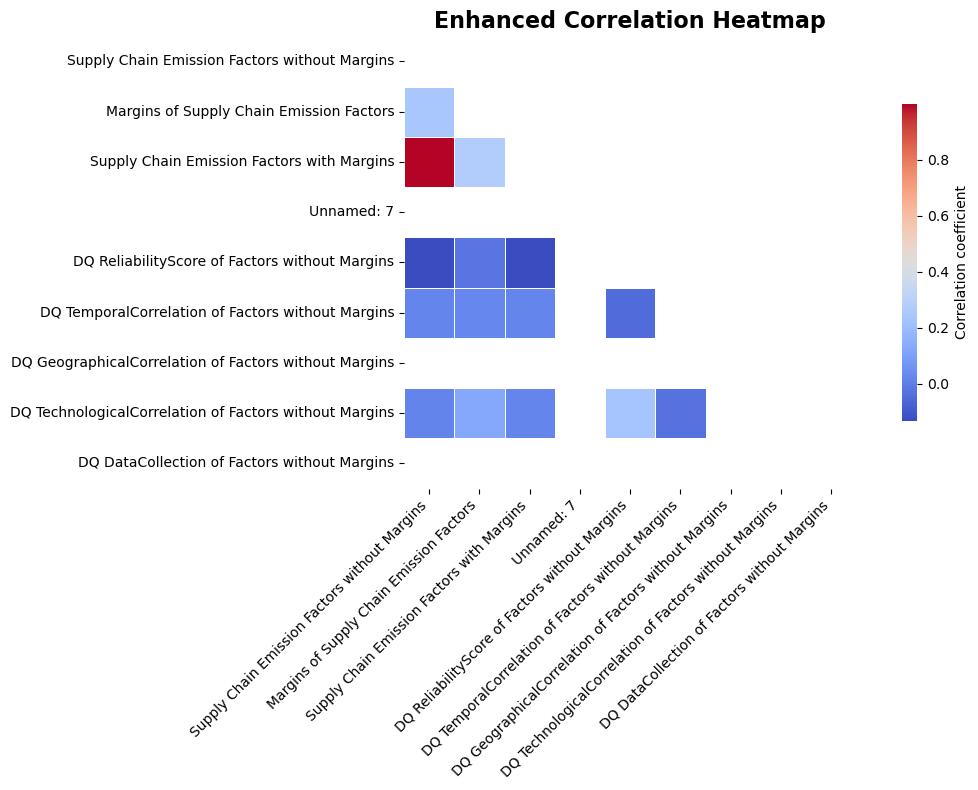

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

corr = df.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  # Mask upper triangle

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    mask=mask,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7, "label": "Correlation coefficient"},
    annot_kws={"size": 10}
)

plt.title("Enhanced Correlation Heatmap", fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [68]:
df.columns


Index(['Industry Code', 'Industry Name', 'Substance', 'Unit',
       'Supply Chain Emission Factors without Margins',
       'Margins of Supply Chain Emission Factors',
       'Supply Chain Emission Factors with Margins', 'Unnamed: 7',
       'DQ ReliabilityScore of Factors without Margins',
       'DQ TemporalCorrelation of Factors without Margins',
       'DQ GeographicalCorrelation of Factors without Margins',
       'DQ TechnologicalCorrelation of Factors without Margins',
       'DQ DataCollection of Factors without Margins'],
      dtype='object')

In [69]:
X = df.drop(columns=['Supply Chain Emission Factors with Margins'])
y = df['Supply Chain Emission Factors with Margins']


In [70]:
X.describe().T


,count,mean,std,min,25%,50%,75%,max
Supply Chain Emission Factors without Margins,1848.0,0.087797,0.292632,0.0,0.0,0.002,0.0415,4.226
Margins of Supply Chain Emission Factors,1848.0,0.002312,0.008689,0.0,0.0,0.000,0.0000,0.073
Unnamed: 7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DQ ReliabilityScore of Factors without Margins,1848.0,3.401515,0.546721,2.0,3.0,3.000,4.0000,4.000
DQ TemporalCorrelation of Factors without Margins,1848.0,2.571429,0.495006,2.0,2.0,3.000,3.0000,3.000
DQ GeographicalCorrelation of Factors without Margins,1848.0,1.000000,0.000000,1.0,1.0,1.000,1.0000,1.000
DQ TechnologicalCorrelation of Factors without Margins,1848.0,2.759199,1.212157,1.0,1.0,3.000,4.0000,5.000
DQ DataCollection of Factors without Margins,1848.0,1.000000,0.000000,1.0,1.0,1.000,1.0000,1.000


In [71]:
X = X.drop(columns=['Industry Code', 'Industry Name', 'Unnamed: 7'], errors='ignore')


In [72]:
substance_map = {'carbon dioxide': 0, 'methane': 1, 'nitrous oxide': 2, 'other GHGs': 3}
unit_map = {'kg/2018 USD, purchaser price': 0, 'kg CO2e/2018 USD, purchaser price': 1}
# Add this if Source column is present
source_map = {'Commodity': 0, 'Industry': 1}

X['Substance'] = X['Substance'].map(substance_map)
X['Unit'] = X['Unit'].map(unit_map)
if 'Source' in X.columns:
    X['Source'] = X['Source'].map(source_map)


In [74]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [75]:
X_scaled.min(axis=0), X_scaled.max(axis=0)


(array([-1.34164079, -0.57735027, -0.30010709, -0.26617941, -2.56418551,
        -1.15470054,  0.        , -1.45168897,  0.        ]),
 array([ 1.34164079,  1.73205081, 14.14516382,  8.13744019,  1.09497652,
         0.8660254 ,  0.        ,  1.84910613,  0.        ]))

In [76]:
np.round(X_scaled.mean()),np.round(X_scaled.std())

(-0.0, 1.0)

In [26]:
# np.round(X_scaled.mean()),np.round(X_scaled.std())

In [77]:
X.shape

(1848, 9)

In [78]:
from sklearn.model_selection import train_test_split


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [81]:
X_train.shape

(1478, 9)

In [82]:
X_test.shape

(370, 9)

In [33]:
# Select the model for training

In [83]:
from sklearn.ensemble import RandomForestRegressor


In [84]:
RF_model = RandomForestRegressor(random_state=42)


In [37]:
# Step 4: Training

In [85]:
RF_model.fit(X_train, y_train) # Fitting the model on training data 

RandomForestRegressor(random_state=42)

In [39]:
# Step 5 Prediction and Evaluation

In [86]:
RF_y_pred = RF_model.predict(X_test) # Making predictions on the test set 

In [87]:
RF_y_pred[:20]

array([1.40000000e-02, 1.59700000e-01, 8.57900000e-02, 2.00000000e-03,
       4.17770000e-01, 3.00000000e-03, 1.33910000e-01, 4.15940000e-01,
       0.00000000e+00, 1.08685618e-03, 0.00000000e+00, 2.24690000e-01,
       2.78200000e-01, 2.00000000e-03, 2.38260000e-01, 8.62313100e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [92]:
from sklearn.metrics import mean_squared_error, r2_score

RF_mse = mean_squared_error(y_test, RF_y_pred)
RF_rmse = np.sqrt(RF_mse)
RF_r2 = r2_score(y_test, RF_y_pred)

print(f'RMSE: {RF_rmse}')
print(f'R² Score: {RF_r2}')


RMSE: 0.0029105253866740003
R² Score: 0.9998704106254312


In [90]:
from sklearn.linear_model import LinearRegression # Importing Linear Regression model 
LR_model = LinearRegression() # Initializing Linear Regression model
# Fitting the Linear Regression model on training data

LR_model.fit(X_train, y_train)

LR_y_pred = LR_model.predict(X_test) # Making predictions on the test set using Linear Regression model 


LR_mse = mean_squared_error(y_test, LR_y_pred) # Calculating Mean Squared Error (MSE) for Linear Regression model
LR_rmse = np.sqrt(LR_mse) # Calculating Root Mean Squared Error (RMSE) for Linear Regression model 
LR_r2 = r2_score(y_test, LR_y_pred) # Calculating R² score for Linear Regression model 

print(f'RMSE: {LR_rmse}')
print(f'R² Score: {LR_r2}')

RMSE: 0.00016445446633610447
R² Score: 0.9999995862691019


In [46]:
# Step 6: Hyperparameter Tuning

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],         # Number of trees
    'max_depth': [None, 10, 20],        # Max depth of tree
    'min_samples_split': [2, 5]         # Minimum samples to split a node
}

# Set up the GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,                   # 3-fold cross-validation
    scoring='r2',           # Scoring metric (you can use 'neg_mean_squared_error' too)
    n_jobs=-1               # Use all available CPU cores
)

# Fit the grid search to training data
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_rf_model = grid_search.best_estimator_
print(" Best Parameters:", grid_search.best_params_)


 Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [48]:
# Use best parameters for predictionUse best parameters for prediction

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Grid search with cross-validation
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Save best model
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [95]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred_best = best_rf_model.predict(X_test)

HP_mse = mean_squared_error(y_test, y_pred_best)
HP_rmse = np.sqrt(HP_mse)
HP_r2 = r2_score(y_test, y_pred_best)

print(f'RMSE: {HP_rmse:.4f}')
print(f'R² Score: {HP_r2:.4f}')


RMSE: 0.0029
R² Score: 0.9999


In [52]:
# Step 7: Comapartive Study and Slecting the Best model

In [96]:
# Create a comparative DataFrame for all models
results = {
    'Model': ['Random Forest (Default)', 'Linear Regression', 'Random Forest (Tuned)'],
    'MSE': [RF_mse, LR_mse, HP_mse],
    'RMSE': [RF_rmse, LR_rmse, HP_rmse],
    'R2': [RF_r2, LR_r2, HP_r2]
}

# Create a DataFrame to compare the results of different models
comparison_df = pd.DataFrame(results)
print(comparison_df)

                     Model           MSE      RMSE        R2
0  Random Forest (Default)  8.471158e-06  0.002911  0.999870
1        Linear Regression  2.704527e-08  0.000164  1.000000
2    Random Forest (Tuned)  8.554171e-06  0.002925  0.999869


In [55]:
# Save model and encoders

In [98]:
# Create a directory to save the models if it doesn't exist 
!mkdir models 

A subdirectory or file models already exists.


In [101]:
import joblib
joblib.dump(best_rf_model, 'models/rf_tuned_model.pkl')  # Save tuned Random Forest model
joblib.dump(scaler, 'models/scaler.pkl')              # Save StandardScaler


['models/scaler.pkl']

In [102]:
import os
print(os.getcwd())


C:\Users\satya
